# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)



<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np
from q3dfit.common import questfit_readcf

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [2]:
# Input files
infile = '../test/test_questfit/22128896_mock_cube.fits'

# Output directories/files
outdir = ''
logfile = outdir+'test_questfit_fitlog.txt'
path_to_npy_file = outdir # path for initproc.npy



Some general information about your cube:

In [3]:
ncols = 17 # number of columns
nrows = 26 # number of rows
platescale = 0.3

fitrange = np.array([5.422479152679443, 29.980998992919922])  # micron

if not os.path.isfile(infile): print('Data cube not found.')

In [4]:
### more MIR settings
#   These are unique to the user
global_ice_model = 'ice_hc'
global_ext_model = 'CHIAR06'
cffilename = '../test/test_questfit/22128896.cf'
config_file = questfit_readcf.readcf(cffilename)

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [5]:
lines = ['[NeII]12.81', '[ArII]6.99', '[SIII]18.71', '[NeIII]15.56', 'H2_65_O13', '[ArIII]8.99']

How many components do you want to be fitted to the emission lines?

In [6]:
maxncomp = 1

In [7]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = '[NeII]12.81'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.)
    siginit_gas[i] = np.full(maxncomp, 1000.) #0.1) #1000.)
    zinit_stars=np.full((ncols,nrows),0.0)

    

# Parameters for emission line plotting
linoth = np.full((1, 1), '', dtype=object)
linoth[0, 0] = '[[NeII]12.81'
argspltlin1 = {'nx': 1, #3,
               'ny': 1, #2,
               'label': ['[Ne II] 12.8'],
               'wave': [128130.0],
               'off': [[-120,90]],
               'linoth': linoth}

# Velocity dispersion limits and fixed values
siglim_gas = np.ndarray(2)
siglim_gas[:] = [5, 4000]


#
# Output structure
#

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [8]:
initproc = { \
            # Required pars
            'fcninitpar': 'parinit', #'gmos',
            'fitran': fitrange,
            'fluxunits': 1,
            'infile': infile,
            'label':
                config_file['source'][0].replace('.ideos','').replace('.npy', ''),
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'name': 'IRAS21219m1757_dlw_qst',
            'ncomp': ncomp,
            'outdir': outdir,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': 0.0,
            # Optional pars
            'argscontfit': {'config_file': cffilename,
                            'global_ice_model': global_ice_model,
                            'global_ext_model': global_ext_model,
                            'models_dictionary': {},
                            'template_dictionary': {}},
            'argslinelist': {'vacuum': False},
            #'argspltlin1': argspltlin1,
            'fcncheckcomp': 'checkcomp',
            'fcncontfit': 'questfit',
            'maskwidths_def': 500,
            'emlsigcut': 2,
            'logfile': logfile,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'siginit_stars': 100,
            'nocvdf': 1,
            'waveext': 4,
            'datext': 1,
            'varext': 2,
            'dqext': 3,
            'zerodq': True,
            'argsreadcube': {'fluxunit_in': 'Jy',
                            'waveunit_in': 'angstrom',
                            'waveunit_out': 'micron'},          
            'plotMIR': True,
        }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [ ]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [9]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [10]:
cols = [1]
rows = [1]

Line(s)      name    
------------
 [NeII]12.81
  [ArII]6.99
 [SIII]18.71
[NeIII]15.56
   H2_65_O13
 [ArIII]8.99  outside of Morton validity for conversion to air
local variable 'header' referenced before assignment
... Continuing anyway ...
FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1
FITSPEC: Continuum fit took 0.3 s.
[[Model]]
    (((((Model(manygauss, prefix='lbNeIIrb12pt81_0_') + Model(manygauss, prefix='lbArIIrb6pt99_0_')) + Model(manygauss, prefix='lbSIIIrb18pt71_0_')) + Model(manygauss, prefix='lbNeIIIrb15pt56_0_')) + Model(manygauss, prefix='H2_65_O13_0_')) + Model(manygauss, prefix='lbArIIIrb8pt99_0_'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 9
    # data points      = 310
    # variables        = 7
    chi-square         = 5.1990e+08
    reduced chi-square = 1715849.96
    Akaike info crit   = 4457.09968
    Bayesian info crit = 4483.25569
[[Variables]]
    lbNeIIrb12pt81_0_flx:         0.04692531 +/- 0.00875939 (18.67%) (init = 0.0

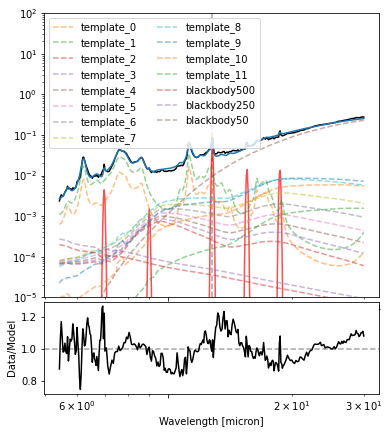

FITSPEC: Line fit took 1.1 s.
FITLOOP: Second call to FITSPEC
1.0
1.0
1.0
1
FITSPEC: Continuum fit took 0.3 s.
[[Model]]
    (((((Model(manygauss, prefix='lbNeIIrb12pt81_0_') + Model(manygauss, prefix='lbArIIrb6pt99_0_')) + Model(manygauss, prefix='lbSIIIrb18pt71_0_')) + Model(manygauss, prefix='lbNeIIIrb15pt56_0_')) + Model(manygauss, prefix='H2_65_O13_0_')) + Model(manygauss, prefix='lbArIIIrb8pt99_0_'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 310
    # variables        = 7
    chi-square         = 3.0462e+08
    reduced chi-square = 1005337.11
    Akaike info crit   = 4291.37814
    Bayesian info crit = 4317.53414
[[Variables]]
    lbNeIIrb12pt81_0_flx:         0.04674532 +/- 0.00729046 (15.60%) (init = 0.04692531)
    lbNeIIrb12pt81_0_cwv:         12.8165260 +/- 0.00603863 (0.05%) (init = 12.81839)
    lbNeIIrb12pt81_0_sig:         1084.59306 +/- 131.149664 (12.09%) (init = 1218.091)
    lbNeIIrb12pt81_0_srsigsla

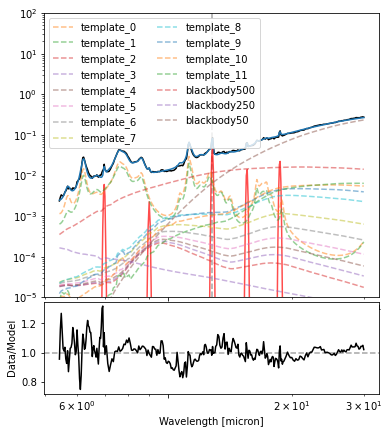

FITSPEC: Line fit took 0.9 s.


In [11]:
q3df(initproc, cols=cols, rows=rows, quiet=False)

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg')
q3da(initproc, cols=cols, rows=rows, quiet=False)

In [ ]:
%matplotlib